Number of reactants: 2
Number of products: 2


Reactant 1:


Reactant: benzene


Reactant 2:


Reactant: dioxygene


Product 1:


Product: water


Product 2:


Product: carbon dioxyde


Invalid SMILES format. Please enter a valid SMILES string.


Product: O=C=O


Invalid SMILES format. Please enter a valid SMILES string.


Product: carbon dioxide


Reactants: ['C1=CC=CC=C1', 'O=O']
Products: ['O', 'C(=O)=O']

 
 stoechiometric reaction is C6H6 + 7 O2 → 2 H2O + 6 CO2

 
 representation of the reaction:


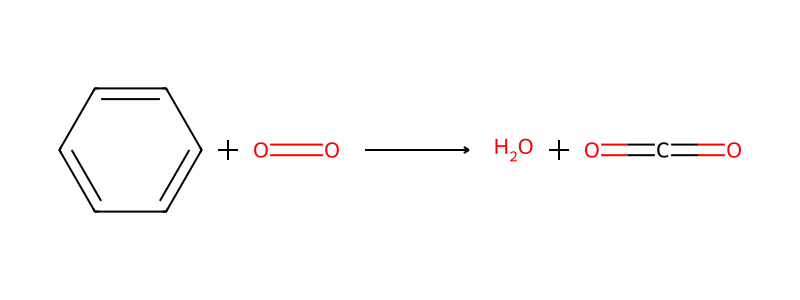

In [7]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from collections import defaultdict
import pulp
from PIL import Image
import io
import tempfile
import webbrowser
import pandas as pd
from rxnmapper import RXNMapper
from rxn_insight.reaction import Reaction
from rxn_insight.utils import draw_chemical_reaction, curate_smirks, get_similarity, get_fp
from IPython.display import SVG, display
import time
import requests

def validate_nonzero_integer(input_value): #regarde si l'input est non nul 
    try:
        value = int(input_value)
        if value != 0:
            return True
        else:
            return False
    except ValueError:
        return False

def get_nonzero_integer(prompt, max_reactants=4): #regarde si c'est un int et qu'il est compris entre 1 & 4
    while True:
        input_value = input(prompt)
        if validate_nonzero_integer(input_value):
            number_of_reactants = int(input_value)
            if number_of_reactants <= max_reactants:
                return number_of_reactants
            else:
                print(f"Number of reactants should not exceed {max_reactants}.")
        else:
            print("Invalid input. Please enter a non-zero integer.")

n_reactants = get_nonzero_integer("Number of reactants:")
n_products = get_nonzero_integer("Number of products:")

reactants = []
products = []

def get_smiles_from_name(name):
    """Fetch the SMILES string of a molecule by its common name from PubChem."""
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/property/CanonicalSMILES/JSON"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        smiles = data['PropertyTable']['Properties'][0]['CanonicalSMILES']
        return smiles
    else:
        return "No data found or error occurred."

def is_valid_smiles(molecule):
    if Chem.MolFromSmiles(molecule) is None:
        return False
    else:
        return True

def get_valid_smiles(prompt):
    while True:
        molecule = get_smiles_from_name(input(prompt))
        if is_valid_smiles(molecule):
            return molecule
        else:
            print("Invalid SMILES format. Please enter a valid SMILES string.")

reactants = []
for i in range(n_reactants):
    print(f"Reactant {i+1}:")
    reactant = get_valid_smiles("Reactant:")
    if reactant:
        reactants.append(reactant)

products = []
for i in range(n_products):
    print(f"Product {i+1}:")
    product = get_valid_smiles("Product:")
    if product:
        products.append(product)

print("Reactants:", reactants)
print("Products:", products)

def count_atoms(smiles):
    """ Count atoms in a SMILES string. """
    mol = Chem.MolFromSmiles(smiles)
    atom_counts = defaultdict(int)
    if mol:
        for atom in mol.GetAtoms():
            atom_counts[atom.GetSymbol()] += 1
    return dict(atom_counts)

def setup_matrix(elements, compounds):
    """ Create a stoichiometry matrix for the elements and compounds. """
    matrix = []
    for element in elements:
        row = [compound.get(element, 0) for compound in compounds]
        matrix.append(row)
    return np.array(matrix, dtype=int)

def solve_ilp(A):
    """ Solve the integer linear programming problem to find stoichiometric coefficients. """
    num_vars = A.shape[1]
    prob = pulp.LpProblem("Balancing_Chemical_Equation", pulp.LpMinimize)
    x_vars = [pulp.LpVariable(f'x{i}', lowBound=1, cat='Integer') for i in range(num_vars)]
    prob += pulp.lpSum(x_vars)  # Minimize the sum of coefficients
    for i in range(A.shape[0]):
        prob += pulp.lpDot(A[i, :], x_vars) == 0, f"Element_{i}_balance"
    solver = pulp.PULP_CBC_CMD(msg=False)
    prob.solve(solver)
    if pulp.LpStatus[prob.status] == 'Optimal':
        return [int(pulp.value(var)) for var in x_vars]
    else:
        raise RuntimeError("Failed to find a valid solution.")

def get_molecular_formula(smiles):
    molecule = Chem.MolFromSmiles(smiles)
    if molecule is not None:
        return Chem.rdMolDescriptors.CalcMolFormula(molecule)
    else:
        return "Invalid SMILES string"

def balance_chemical_equation(reactant_smiles, product_smiles):
    """ Balance a chemical equation given reactants and products as SMILES strings. """
    reactant_counts = [count_atoms(smiles) for smiles in reactant_smiles]
    product_counts = [count_atoms(smiles) for smiles in product_smiles]
    
    reactant_elements = set(sum([list(counts.keys()) for counts in reactant_counts], []))
    product_elements = set(sum([list(counts.keys()) for counts in product_counts], []))

    if reactant_elements != product_elements:
        missing_in_products = reactant_elements - product_elements
        missing_in_reactants = product_elements - reactant_elements
        error_message = "Element mismatch found: "
        if missing_in_products:
            error_message += f"Elements {missing_in_products} are in reactants but not in products. "
        if missing_in_reactants:
            error_message += f"Elements {missing_in_reactants} are in products but not in reactants."
        raise ValueError(error_message)

    elements = sorted(reactant_elements.union(product_elements))
    A_reactants = setup_matrix(elements, reactant_counts)
    A_products = setup_matrix(elements, product_counts)
    A = np.concatenate([A_reactants, -A_products], axis=1)
    
    integer_coefficients = solve_ilp(A)
    reactant_coeffs = integer_coefficients[:len(reactant_smiles)]
    product_coeffs = integer_coefficients[len(reactant_smiles):]
    
    reactant_data = [(coeff, get_molecular_formula(smiles)) for coeff, smiles in zip(reactant_coeffs, reactant_smiles)]
    product_data = [(coeff, get_molecular_formula(smiles)) for coeff, smiles in zip(product_coeffs, product_smiles)]

    return reactant_data, product_data

def display_reaction(reactants, products):
    """ Format and display the chemical reaction. """
    def format_component(component):
        if len(component) != 2 or not isinstance(component[0], int) or not isinstance(component[1], str):
            raise ValueError("Each component must be a tuple of (coefficient, molecule), with a valid integer and string.")
        coefficient, molecule = component
        return f"{coefficient} {molecule}" if coefficient != 1 else molecule

    if not reactants or not products:
        raise ValueError("Both reactants and products need at least one component.")

    reactants_str = ' + '.join(format_component(r) for r in reactants)
    products_str = ' + '.join(format_component(p) for p in products)
    reaction = f"{reactants_str} → {products_str}"
    
    return reaction

def create_reaction_string(reactants, products): #passes from 2 lists of smiles to a string of reaction for later display 
    reactants_str = '.'.join(reactants)
    products_str = '.'.join(products)
    reaction = f"{reactants_str}>>{products_str}"
    return reaction

try:
    reactant_data, product_data = balance_chemical_equation(reactants, products)
    reaction_string = display_reaction(reactant_data, product_data)
    reaction_str = create_reaction_string(reactants, products)
    print("\n \n", "stoechiometric reaction is", reaction_string)
    print("\n \n", "representation of the reaction:")
    display(SVG(draw_chemical_reaction(reaction_str)))
except ValueError as e:
    print(e)